In [26]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os

import logging
logging.getLogger().setLevel(logging.INFO)

from alphabase.spectral_library.flat import SpecLibFlat
from alphabase.spectral_library.base import SpecLibBase
from alphabase.spectral_library.reader import LibraryReaderBase
from tqdm import tqdm
from alphabase.peptide.precursor import get_mod_seq_formula
from alphabase.constants.isotope import IsotopeDistribution
from alphadia.extraction.utils import reannotate_fragments
from alphabase.psm_reader import psm_reader_provider

In [27]:
import warnings 

def fragment_number(precursor_df, fragment_intensity_df) :
    if not set(['frag_start_idx', 'frag_stop_idx']).issubset(precursor_df.columns):
        warnings.warn('frag_start_idx and frag_stop_idx not in dataframe')
        return
    
    n_fragments = []
    
    for start, stop in zip(precursor_df['frag_start_idx'].values, precursor_df['frag_stop_idx'].values):
        n_fragments += [np.sum(fragment_intensity_df.iloc[start:stop].values > 0)]

    precursor_df['n_fragments'] = n_fragments

def calc_isotope_dist(precursor_df, max_isotope = 6, min_intensity = 0.001):
    isotope_dist = IsotopeDistribution()

    col_names = ['i_{}'.format(i) for i in range(max_isotope)]
    precursor_df[col_names] = 0.

    for i in tqdm(range(len(precursor_df))):

        row = precursor_df.iloc[i]
        dist, mono = isotope_dist.calc_formula_distribution(
            get_mod_seq_formula(row['sequence'], row['mods'])
        )
        dist[dist < 0.001] = 0.
        dist = dist / dist.sum()
        precursor_df.loc[i, col_names] = dist[:max_isotope]

In [58]:
lib_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/MSfragger_library_mod_noLossType.tsv'
#insilico_lib_location = '/Users/georgwallmann/Documents/data/libraries/2022_111_brunner_2022_1ng_all_29_human_trypsin_diann_decoy.hdf'
output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/MSfragger_library_mod_noLossType_d0_d4_d8_shared_eg_n_fragments.hdf'

In [29]:
# create dense library from diann psm file
target_lib = LibraryReaderBase()
target_lib.add_modification_mapping(
    {'Oxidation@M':['M(Oxidation)'],
     'Dimethyl@K':['K(Dimethyl)'],
     'Dimethyl@R':['R(Dimethyl)'],
     'Dimethyl@Any N-term':['(Dimethyl)']
    }
)
psm = target_lib.import_file(lib_location)

In [30]:
target_lib.fragment_mz_df

,b_z1,b_z2,y_z1,y_z2,b_modloss_z1,b_modloss_z2,y_modloss_z1,y_modloss_z2
0,185.139688,93.073482,1162.547390,581.777333,0.0,0.0,0.0,0.0
1,341.265951,171.136614,1006.421127,503.714202,0.0,0.0,0.0,0.0
2,470.308544,235.657910,877.378533,439.192905,0.0,0.0,0.0,0.0
3,599.351137,300.179207,748.335940,374.671608,0.0,0.0,0.0,0.0
4,728.393730,364.700503,619.293347,310.150312,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
554114,1499.767043,750.387160,653.350468,327.178872,0.0,0.0,0.0,0.0
554115,1662.830371,831.918824,490.287140,245.647208,0.0,0.0,0.0,0.0
554116,1749.862400,875.434838,403.255111,202.131194,0.0,0.0,0.0,0.0
554117,1862.946464,931.976870,290.171047,145.589162,0.0,0.0,0.0,0.0


In [31]:

target_lib.precursor_df['decoy'] = 0
target_lib._precursor_df['channel'] = 0
target_lib._fragment_mz_df = target_lib._fragment_mz_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]
target_lib._fragment_intensity_df = target_lib._fragment_intensity_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)
target_lib._precursor_df['elution_group_idx'] = np.arange(len(target_lib._precursor_df))

In [32]:
calc_isotope_dist(target_lib.precursor_df)

100%|██████████| 45867/45867 [00:18<00:00, 2450.74it/s]


In [33]:
from alphabase.peptide import fragment

channel_lib_list = []
for channel, original_mod, new_mod in [
    (4, 'Dimethyl@', 'Dimethyl:2H(4)@'),
    (8, 'Dimethyl@', 'Dimethyl:2H(6)13C(2)@')
    ]:

    channel_lib = target_lib.copy()

    channel_lib._precursor_df['mods'] = channel_lib._precursor_df['mods'].str.replace(original_mod, new_mod)
    channel_lib._precursor_df['channel'] = channel
    fragment.update_precursor_mz(channel_lib._precursor_df)
    channel_lib.calc_fragment_mz_df()
    channel_lib_list += [channel_lib]
    channel_lib.precursor_df.head()


In [34]:
for lib in channel_lib_list:
    target_lib.append(lib)

/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'b_modloss_z1', 'y_modloss_z1', 'y_modloss_z2', 'b_modloss_z2'}.
  warnings.warn(
/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'b_modloss_z1', 'y_modloss_z1', 'y_modloss_z2', 'b_modloss_z2'}.
  warnings.warn(


In [35]:
target_lib.precursor_df.sort_values('elution_group_idx', inplace=True)
target_lib.remove_unused_fragments()

In [36]:
decoy_lib = SpecLibBase()
decoy_lib._precursor_df = target_lib.precursor_df.copy()
decoy_lib._fragment_mz_df = target_lib._fragment_mz_df.copy()
decoy_lib._fragment_intensity_df = target_lib._fragment_intensity_df.copy()


#decoy_lib.import_file(brunner_lib)
decoy_lib.decoy = 'diann'
decoy_lib.append_decoy_sequence()
decoy_lib.precursor_df = decoy_lib.precursor_df[decoy_lib.precursor_df['decoy'] == 1]
fragment.update_precursor_mz(decoy_lib._precursor_df)
#decoy_lib.calc_precursor_mz()


,rt,precursor_mz,nAA,charge,mods,proteins,sequence,genes,mod_sites,mobility,...,decoy,channel,n_fragments,elution_group_idx,i_0,i_1,i_2,i_3,i_4,i_5
0,30.321771,406.256895,7,2,Dimethyl:2H(6)13C(2)@Any N-term,Q6UXN9,LSDSVVR,WDR82,0,0.831209,...,1,8,8,13763,0.632860,0.276845,0.073483,0.014490,0.002322,0.000000
1,33.479814,457.303710,7,2,Dimethyl:2H(6)13C(2)@Any N-term;Oxidation@M;Di...,Q96ST2-3,ALMYLSK,IWS1,0;3;7,0.870136,...,1,8,7,15609,0.538746,0.300379,0.117387,0.034140,0.007855,0.001493
2,15.456160,433.280370,7,2,Dimethyl:2H(6)13C(2)@Any N-term,Q15056,VEIAELR,EIF4H,0,0.777179,...,1,8,10,5948,0.654174,0.264341,0.066888,0.012645,0.001952,0.000000
3,47.350412,416.309849,7,2,Dimethyl:2H(6)13C(2)@Any N-term;Dimethyl:2H(6)...,O94826,GVELITK,TOMM70,0;7,0.768646,...,1,8,8,23419,0.625154,0.282478,0.075243,0.014779,0.002345,0.000000
4,47.353311,468.341149,7,2,Dimethyl:2H(6)13C(2)@Any N-term;Dimethyl:2H(6)...,P78527,ILELFTK,PRKDC,0;7,0.798724,...,1,8,7,23421,0.605488,0.293099,0.081898,0.016757,0.002758,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137590,13.505330,941.221388,49,4,Dimethyl:2H(4)@Any N-term;Dimethyl:2H(4)@K,Q9UKY7,ALSAAGAAGSAGGSSGAAGAAGGGAGAGTRPGDGGTASAGAAGPGAASK,CDV3,0;49,1.120423,...,1,4,75,4695,0.141394,0.260841,0.256465,0.177225,0.096112,0.043393
137591,13.564690,753.178566,49,5,Dimethyl:2H(4)@Any N-term;Dimethyl:2H(4)@K,Q9UKY7,ALSAAGAAGSAGGSSGAAGAAGGGAGAGTRPGDGGTASAGAAGPGAASK,CDV3,0;49,1.095016,...,1,4,47,4731,0.141394,0.260841,0.256465,0.177225,0.096112,0.043393
137592,13.564690,754.786271,49,5,Dimethyl:2H(6)13C(2)@Any N-term;Dimethyl:2H(6)...,Q9UKY7,ALSAAGAAGSAGGSSGAAGAAGGGAGAGTRPGDGGTASAGAAGPGAASK,CDV3,0;49,1.095016,...,1,8,47,4731,0.141394,0.260841,0.256465,0.177225,0.096112,0.043393
137593,13.564690,751.568523,49,5,Dimethyl@Any N-term;Dimethyl@K,Q9UKY7,ALSAAGAAGSAGGSSGAAGAAGGGAGAGTRPGDGGTASAGAAGPGAASK,CDV3,0;49,1.095016,...,1,0,47,4731,0.141394,0.260841,0.256465,0.177225,0.096112,0.043393


In [37]:
from peptdeep.pretrained_models import ModelManager
from alphabase.peptide.fragment import get_charged_frag_types

model_mgr = ModelManager()

model_mgr.nce = 30
model_mgr.instrument = 'timsTOF'

In [38]:
decoy_lib.charged_frag_types = target_lib.charged_frag_types

In [39]:
res = model_mgr.predict_all(
    decoy_lib.precursor_df,
    predict_items=['ms2'],
    frag_types = decoy_lib.charged_frag_types,
)
#decoy_lib.calc_fragment_mz_df()

2023-04-06 22:10:18> Using multiprocessing with 8 processes ...
2023-04-06 22:10:18> Predicting ms2 ...


100%|██████████| 43/43 [00:33<00:00,  1.27it/s]


In [40]:
decoy_lib._precursor_df = res['precursor_df']
decoy_lib._fragment_mz_df = res['fragment_mz_df']
decoy_lib._fragment_intensity_df = res['fragment_intensity_df']

In [41]:
target_lib.append(decoy_lib)

/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'nce', 'instrument'}.
  warnings.warn(
/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'b_modloss_z1', 'y_modloss_z1', 'y_modloss_z2', 'b_modloss_z2'}.
  warnings.warn(


In [42]:
target_lib.precursor_df['n_fragments_allowed'] = target_lib.precursor_df['n_fragments']

In [43]:
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)

In [24]:
allowed = target_lib.precursor_df.groupby('elution_group_idx')[['n_fragments']].min().reset_index()

In [25]:
allowed

,elution_group_idx,n_fragments
0,0,10
1,1,9
2,2,11
3,3,6
4,4,10
...,...,...
45862,45862,18
45863,45863,17
45864,45864,16
45865,45865,17


In [49]:
target_lib.precursor_df.drop(columns=['n_fragments_allowed'], inplace=True)

In [50]:
target_lib.precursor_df = target_lib.precursor_df.merge(allowed, on='elution_group_idx', suffixes=['', '_allowed'])

In [51]:
target_lib.precursor_df[['n_fragments_allowed']]

,n_fragments_allowed
0,6
1,6
2,6
3,6
4,6
...,...
275191,19
275192,19
275193,19
275194,19


<AxesSubplot:xlabel='n_fragments', ylabel='Count'>

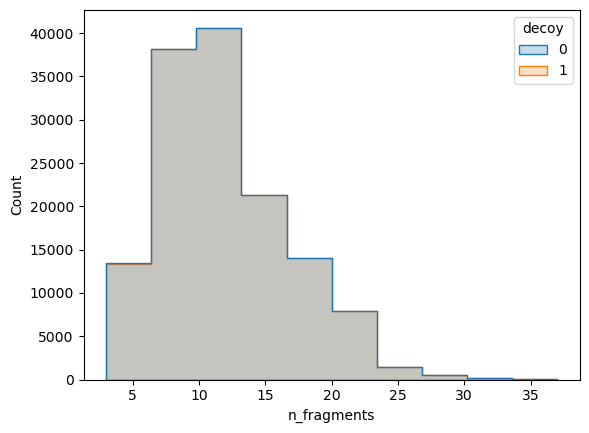

In [57]:
import seaborn as sns
sns.histplot(target_lib.precursor_df, x='n_fragments', hue='decoy', element='step', bins=10)

In [53]:
for i, (start_idx, stop_idx, k_allowed) in enumerate(
    zip(
        target_lib.precursor_df['frag_start_idx'].values, 
        target_lib.precursor_df['frag_stop_idx'].values, 
        target_lib.precursor_df['n_fragments_allowed'].values
        )
    ):
    intensies = target_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values
    flat_intensities = np.sort(intensies.flatten())[::-1]
    target_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values[intensies <= flat_intensities[k_allowed]] = 0

In [54]:
target_lib.precursor_df.drop(columns=['n_fragments'], inplace=True)

In [55]:
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)
target_lib.fragment_cardinality_df = fragment.calc_fragment_cardinality(target_lib.precursor_df, target_lib._fragment_mz_df)

In [59]:
target_lib.save_hdf(output_location)